# CBC Waveform in wavelet domain

## Basic Waveform

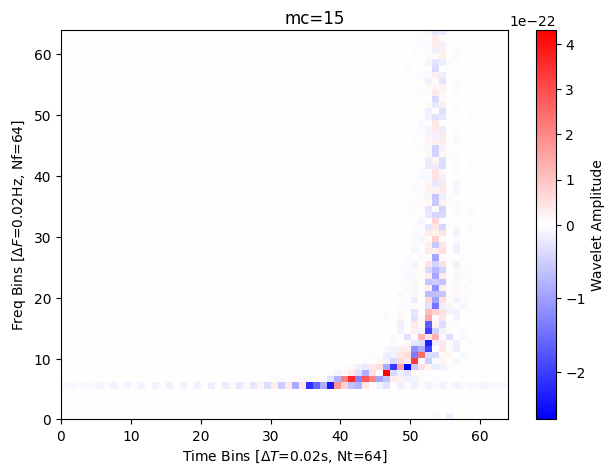

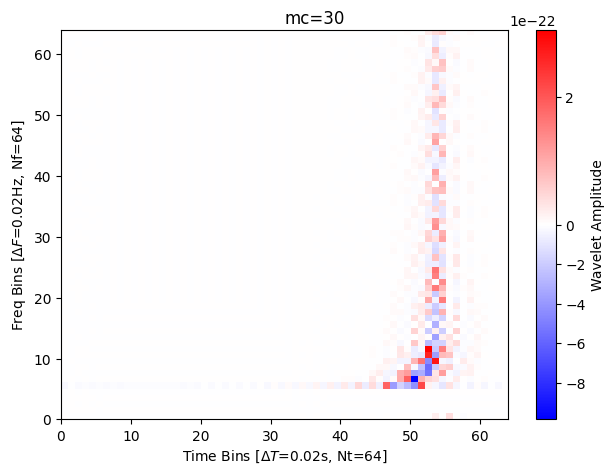

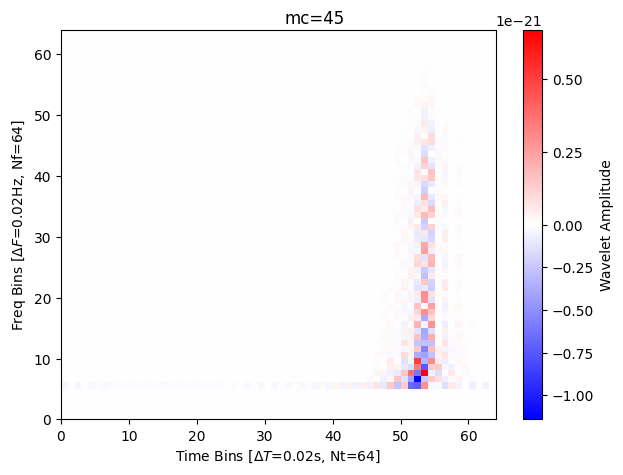

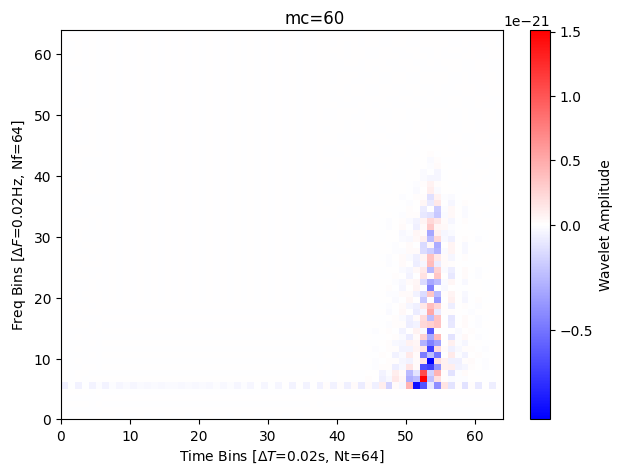

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from pycbc.conversions import mass1_from_mchirp_q, mass2_from_mchirp_q
from pywavelet.waveform_generator.generators import FunctionalWaveformGenerator
import matplotlib.colors as colors

import bilby
import numpy as np
import logging

bilby_logger = logging.getLogger("bilby")
bilby_logger.setLevel(logging.ERROR)

DURATION = 8
SAMPLING_FREQUENCY = 512
MINIMUM_FREQUENCY = 20

CBC_GENERATOR = bilby.gw.WaveformGenerator(
    duration=DURATION,
    sampling_frequency=SAMPLING_FREQUENCY,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(
        waveform_approximant="IMRPhenomD",
        reference_frequency=20.0,
        minimum_frequency=MINIMUM_FREQUENCY,
    )
)

GW_PARMS = dict(
    mass_1=30, mass_2=30,  # 2 mass parameters
    a_1=0.1, a_2=0.1, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0,  # 6 spin parameters
    ra=1.375, dec=-1.2108, luminosity_distance=2000.0, theta_jn=0.0,  # 7 extrinsic parameters
    psi=2.659, phase=1.3,
    geocent_time=1126259642.413,
)


def cbc_waveform(mc, q=1):
    m1, m2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(mc, q)

    params = GW_PARMS.copy()
    params['mass_1'] = m1
    params['mass_2'] = m2

    h = CBC_GENERATOR.time_domain_strain(params)['plus']
    # template sets max amplitude t=end of waveform, so we roll it back a bit
    h = np.roll(h, - len(h) // 6)
    t = CBC_GENERATOR.time_array
    return t, h


def plot_wavelet_domain_signal(wavelet_data, Nt, Nf):
    fig = plt.figure()
    norm = colors.TwoSlopeNorm(vmin=wavelet_data.min(), vcenter=0, vmax=wavelet_data.max())
    plt.imshow(
        np.rot90(wavelet_data),
        aspect="auto",
        extent=[0, Nt, 0, Nf],
        cmap='bwr',
        norm=norm
    )
    cbar = plt.colorbar()
    cbar.set_label("Wavelet Amplitude")
    plt.xlabel(r"Time Bins [$\Delta T$=" + f"{1 / Nt:.2f}s, Nt={Nt}]")
    plt.ylabel(r"Freq Bins [$\Delta F$=" + f"{1 / Nf:.2f}Hz, Nf={Nf}]")
    # plt.ylim(*freq_range)
    plt.tight_layout()
    return fig


def create_cbc_wavelet_waveform_generator():
    Nf, Nt = 64, 64
    mult = 16
    hfunc = lambda mc: cbc_waveform(mc, q=1)[1]
    # NOTE: Nf * Nt == len(h) returned from h-func
    waveform_generator = FunctionalWaveformGenerator(hfunc, Nf=Nf, Nt=Nt, mult=mult)
    return waveform_generator


wavelet_generator = create_cbc_wavelet_waveform_generator()
Nf, Nt = wavelet_generator.Nf, wavelet_generator.Nt
for i, mc in enumerate([15, 30, 45, 60]):
    wavelet_matrix = wavelet_generator(mc=mc)
    fig = plot_wavelet_domain_signal(wavelet_matrix, Nf, Nt)
    fig.suptitle(f"mc={mc}")
    fig.show()

## Waveforms in noise

Let's inject the signals into LIGO detector noise (at design sensitivity), compute the SNR in the time and the wavelet domains.

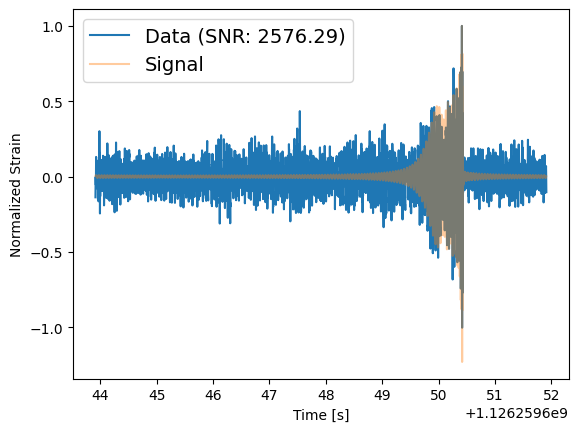

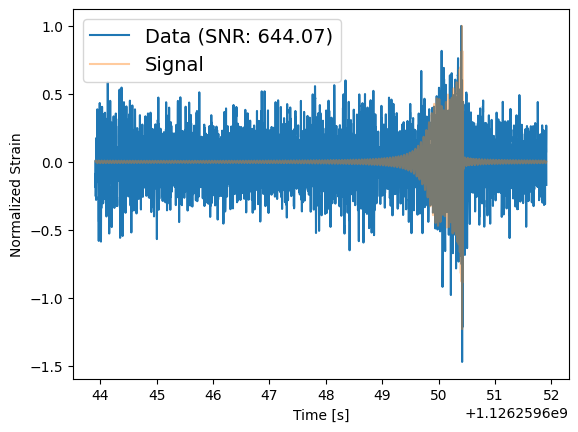

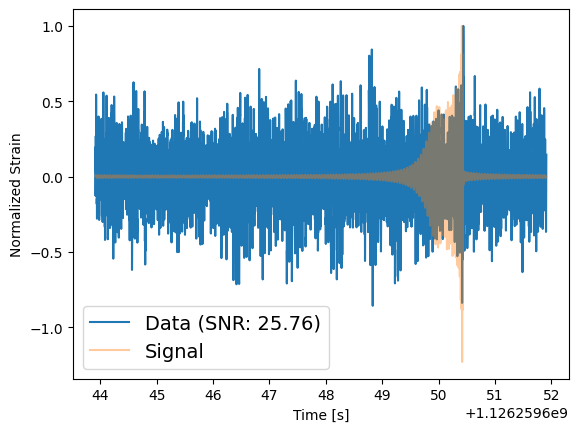

In [52]:
def inject_signal_in_noise(mc, q=1, distance=1000):
    injection_parameters = GW_PARMS.copy()
    injection_parameters["mass_1"], injection_parameters[
        "mass_2"] = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(mc, q)
    injection_parameters["luminosity_distance"] = distance

    ifos = bilby.gw.detector.InterferometerList(["H1"])  # design sensitivity
    ifos.set_strain_data_from_power_spectral_densities(
        sampling_frequency=SAMPLING_FREQUENCY,
        duration=DURATION,
        start_time=injection_parameters["geocent_time"] + 1.5,
    )
    ifos.inject_signal(
        waveform_generator=CBC_GENERATOR, parameters=injection_parameters
    )
    ifo: bilby.gw.detector.Interferometer = ifos[0]

    waveform = CBC_GENERATOR.frequency_domain_strain(injection_parameters)
    signal = ifo.get_detector_response(waveform, injection_parameters)
    snr = ifo.optimal_snr_squared(signal)
    return ifo.time_array, ifo.strain_data.time_domain_strain,  np.abs(snr)


for d in [500, 1000, 5000]:
    t, h, _ = inject_signal_in_noise(mc=30, q=1, distance=0.1)
    _, data, snr = inject_signal_in_noise(mc=30, q=1, distance=d)

    plt.plot(t, data/np.max(data), label=f"Data (SNR: {snr:.2f})")
    plt.plot(t, h/np.max(h), alpha=0.4, label=f"Signal")
    plt.legend(fontsize=14)
    plt.ylabel("Normalized Strain")
    plt.xlabel("Time [s]");
    plt.show()

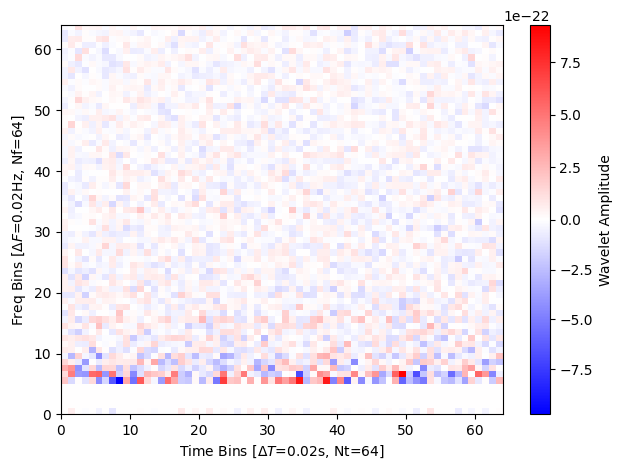

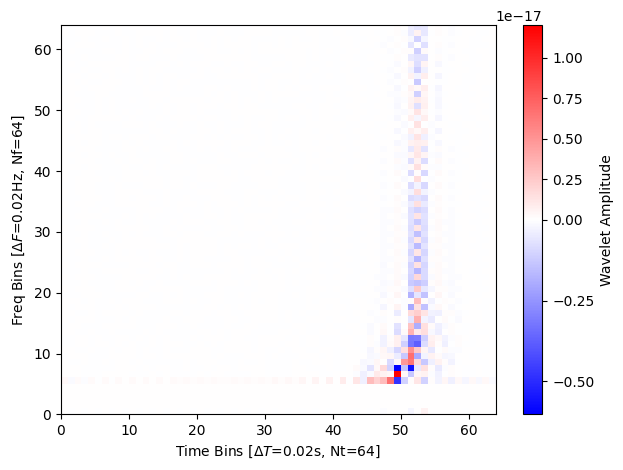

In [55]:
from pywavelet.transforms import from_time_to_wavelet


t, h, _ = inject_signal_in_noise(mc=30, q=1, distance=0.1)
_, data, time_domain_snr = inject_signal_in_noise(mc=30, q=1, distance=5000)
data_wavelet = from_time_to_wavelet(data, Nf, Nt)
h_wavelet = from_time_to_wavelet(h, Nf, Nt)

fig = plot_wavelet_domain_signal(data_wavelet, Nf, Nt)
fig = plot_wavelet_domain_signal(h_wavelet, Nf, Nt)

In [ ]:
from pywavelet.utils.snr import compute_snr

# FOR THE SNR I NEED A PSD...